# 迁移学习

这两个主要的转移学习场景如下：   
* Finetuning the convnet：    
我们使用预训练网络初始化网络，而不是随机初始化，就像在imagenet 1000数据集上训练的网络一样。其余训练看起来像往常一样。
* ConvNet作为固定特征提取器：   
在这里，我们将冻结除最终完全连接层之外的所有网络的权重。最后一个完全连接的层被替换为具有随机权重的新层，并且仅训练该层。

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## 1.加载数据
我们将使用torchvision和torch.utils.data包来加载数据。

我们今天要解决的问题是训练一个模型来对蚂蚁和蜜蜂进行分类 。我们有大约120个训练图像，每个图像用于蚂蚁和蜜蜂。每个类有75个验证图像。通常，如果从头开始训练，这是一个非常小的数据集。由于我们正在使用转移学习，我们应该能够合理地推广。

该数据集是imagenet的一个非常小的子集。

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/hymenoptera'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) 
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 2.可视化一些图像
让我们可视化一些训练图像，以便了解数据增强。

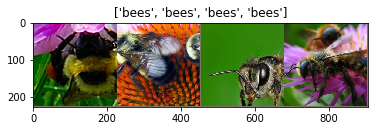

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 3.训练模型
现在，让我们编写一个通用函数来训练模型。在这里，我们将说明：
* 学习率
* 保存最好的模型  
  
在下面，参数scheduler是来自的LR调度程序对象 torch.optim.lr_scheduler。

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## 4.可视化模型预测
用于显示少量图像预测的通用功能

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 5.Finetuning the convnet
加载预训练模型并重置最终完全连接的图层。   
`Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth`

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 6.训练和评估
CPU上需要大约15-25分钟。但是在GPU上，它只需不到一分钟。
pillow版本控制：  
` pip install -i https://pypi.tuna.tsinghua.edu.cn/simple pillow==5.4.1`

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5367 Acc: 0.7172
val Loss: 0.1827 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4977 Acc: 0.7869
val Loss: 0.1495 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4728 Acc: 0.7951
val Loss: 0.4580 Acc: 0.8366

Epoch 3/24
----------
train Loss: 0.6771 Acc: 0.7664
val Loss: 0.7614 Acc: 0.7647

Epoch 4/24
----------
train Loss: 0.5179 Acc: 0.8033
val Loss: 0.2123 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.4453 Acc: 0.8197
val Loss: 0.4263 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.6360 Acc: 0.7951
val Loss: 0.3379 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.4143 Acc: 0.8402
val Loss: 0.3163 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3450 Acc: 0.8320
val Loss: 0.2995 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3681 Acc: 0.8484
val Loss: 0.2657 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.2704 Acc: 0.8893
val Loss: 0.2541 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3404 Acc: 0.8525
val Loss: 0.2318 Acc: 0.9216

Ep

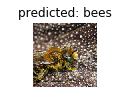

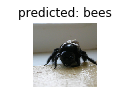

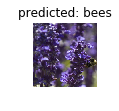

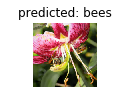

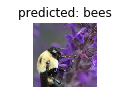

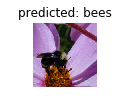

In [8]:
visualize_model(model_ft)

## 7.ConvNet作为固定特征提取器

在这里，我们需要冻结除最后一层之外的所有网络。我们需要设置冻结参数，以便不计算梯度。requires_grad == Falsebackward()

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## 8.训练和评估
在CPU上，与前一个场景相比，这将花费大约一半的时间。这是预期的，因为不需要为大多数网络计算梯度。但是，需要计算转发。

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6714 Acc: 0.6352
val Loss: 0.2886 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.4644 Acc: 0.7746
val Loss: 0.2701 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4244 Acc: 0.7828
val Loss: 0.2956 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.4232 Acc: 0.8197
val Loss: 0.2808 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.5111 Acc: 0.8033
val Loss: 0.1876 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4460 Acc: 0.7910
val Loss: 0.1833 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3801 Acc: 0.8033
val Loss: 0.5628 Acc: 0.7908

Epoch 7/24
----------
train Loss: 0.5522 Acc: 0.7705
val Loss: 0.1540 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3540 Acc: 0.8525
val Loss: 0.1566 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3737 Acc: 0.8484
val Loss: 0.2090 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.4076 Acc: 0.8320
val Loss: 0.1720 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3506 Acc: 0.8361
val Loss: 0.1693 Acc: 0.9477

Ep

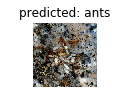

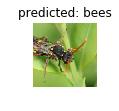

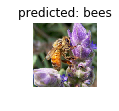

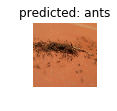

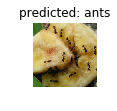

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()